## Optimizers 

Here we introduce optimizers that work on computational graphs.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
from pprint import pprint
from matplotlib import pyplot
%matplotlib inline

We keep using the linear regression problem/model carried over from previous notebooks to demonstrate different optimizer options. 

The cell below generates the toy dataset and defines the model structure. The problem is slightly bigger and the model uses some non-linear activation, which we will cover later.

In [2]:
true_weights = tf.constant(np.array(range(10)), dtype=tf.float32)[:, tf.newaxis]
x = tf.constant(tf.random.uniform((65535, 10)), dtype=tf.float32)
y = tf.constant(x @ true_weights, dtype=tf.float32)
criterion = lambda y, y_hat: tf.reduce_mean(tf.square(y- y_hat))            

class Linear(tf.keras.layers.Layer):
    def __init__(self, units, use_bias=True, relu_activ=False, **kwargs):
        super(Linear, self).__init__(**kwargs)
        self.units = units
        self.use_bias = use_bias
        self.relu_activ = relu_activ
        
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units))
        if self.use_bias:
            self.b = self.add_weight(shape=(self.units), initializer="zeros")
        super().build(input_shape)
        
    @tf.function
    def call(self, x):
        output = tf.matmul(x, self.w)
        if self.use_bias:
            output += self.b
        if self.relu_activ:
            output = tf.maximum(tf.cast(0, dtype=x.dtype), output)
        return output
    
class LinearModel(tf.keras.Model):
    def __init__(self, num_units, use_bias=True, **kwargs):
        super(LinearModel, self).__init__(**kwargs)
        num_layers = len(num_units)
        self.model = [Linear(units, use_bias, relu_activ= i != num_layers) for i, units in enumerate(num_units, 1)]
    
    def call(self, x):
        for layer in self.model:
            x = layer(x)
        return x

### 1 Gradient Descent

Throughout notebook 1 to 3, we have been using the gradient descent optimizer. It works by iteratively updating the model's parameters in the direction of the negative gradients based on the loss/cost/criterion function which measures the discrepancy between the model's outputs and the ground truth.

In [3]:
def gradient_descent_opt(model, criterion, lr, num_epochs=200, record_steps=10):
    history = []
    for it in range(1, num_epochs + 1):
        # forward pass to calculate loss
        with tf.GradientTape() as tape:
            loss = criterion(y, model(x))
        
        # backward pass to calculate gradients
        gradients = tape.gradient(loss, model.variables)
        
        # update parameters in the direction of negative gradients
        for variables, grads in zip(model.variables, gradients):
            variables.assign_add(-lr * grads)
            
        if not it % record_steps:    
            history.append({'epoch': it, 'loss': loss.numpy()})
            
    return model, pd.DataFrame(history)

The important thing to tweak with the gradient descent algorithm is the learning rate, which is the step size of updates, we need to do experiments to find the appropriate learning value per problem. 

In [4]:
def experiment(optimization, **kwargs):
    experiments = []
    for lr in [pow(10, i) for i in range(-4, 0)]:
        model, history = optimization(model=LinearModel(num_units=[5,3,1], use_bias=True), 
                            criterion=criterion, 
                            lr=lr, 
                            **kwargs)
        history['learning_rate'] = lr
        experiments.append(history)

    experiments = pd.concat(experiments, axis=0)
    experiments = experiments.pivot(index='epoch', columns='learning_rate', values='loss')
    experiments.plot(logy=True, figsize=(12,6), linewidth=3)
    return experiments

learning_rate
0.0001    10.549035
0.0010     1.946632
0.0100    23.902603
0.1000    23.717657
dtype: float64


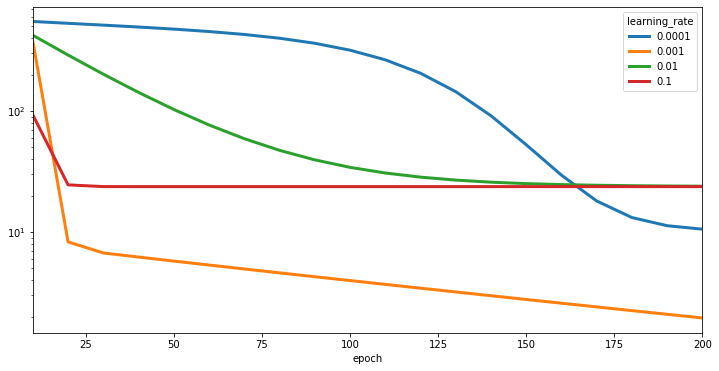

In [5]:
results = experiment(gradient_descent_opt)
print(results.min(axis=0))

### 2 Stochastic Gradient Descent

The problem with gradient descent(SGD) is that it uses the full dataset to compute forward and backward pass and then perform an update. This can be very slow in the case of large datasets and/or models. So an alternative is to use a sample(batch) of the data to estimate the gradient and perform much more frequent updates.

In [6]:
def stochastic_gradient_descent_opt(model, criterion, lr, batch_size=32, num_epochs=100, record_steps=10):
    n = tf.shape(x).numpy()[0]
    steps_per_epoch = n // batch_size
    
    history = []
    for it in range(num_epochs):
        for bt in tqdm(range(steps_per_epoch), 
                       desc='lr {} epoch {}'.format(lr, it + 1), 
                       leave=False):
            sample_indices = tf.convert_to_tensor(np.random.choice(range(n), batch_size))
            x_batch, y_batch = tf.gather(x, sample_indices), tf.gather(y, sample_indices)
            # forward pass to calculate loss
            with tf.GradientTape() as tape:
                loss = criterion(y_batch, model(x_batch))

            # backward pass to calculate gradients
            gradients = tape.gradient(loss, model.variables)

            # update parameters in the direction of negative gradients
            for variables, grads in zip(model.variables, gradients):
                variables.assign_add(-lr * grads)
            
        if not it % record_steps:    
            history.append({'epoch': it, 'loss': loss.numpy()})
            
    return model, pd.DataFrame(history)

learning_rate
0.0001    12.839111
0.0010     0.007501
0.0100     0.035563
0.1000    21.968773
dtype: float64


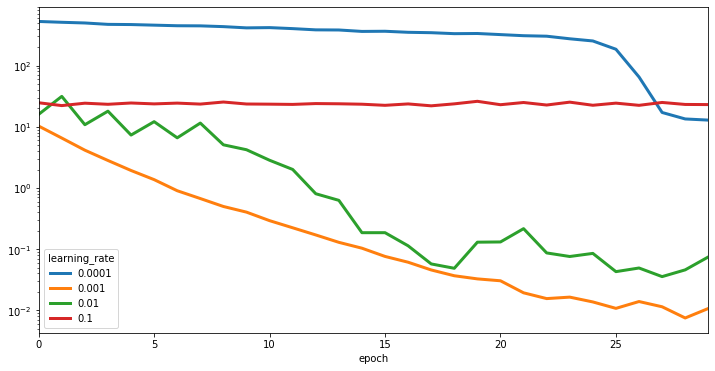

In [7]:
results = experiment(stochastic_gradient_descent_opt, batch_size=1024, num_epochs=30, record_steps=1)
print(results.min(axis=0))

### 3 Work with Optimizers from Tensorflow

Now since we now understand how SGD works and have implemented it ourselves, we are authorized to use the optimizers from Tensorflow. We will just need to replace our custom model parameter update loop with the method call from an optimizer object of choice. 

In [8]:
def opt(model, criterion, optimizer, batch_size=32, num_epochs=100, record_steps=10):
    n = tf.shape(x).numpy()[0]
    steps_per_epoch = n // batch_size
    
    history = []
    for it in range(num_epochs):
        for bt in tqdm(range(steps_per_epoch), 
                       desc='optimizer {} epoch {}'.format(optimizer._name, it + 1), 
                       leave=False):
            sample_indices = tf.convert_to_tensor(np.random.choice(range(n), batch_size))
            x_batch, y_batch = tf.gather(x, sample_indices), tf.gather(y, sample_indices)
            # forward pass to calculate loss
            with tf.GradientTape() as tape:
                loss = criterion(y_batch, model(x_batch))

            # backward pass to calculate gradients
            gradients = tape.gradient(loss, model.variables)
            
            # use optimizer object to do update
            optimizer.apply_gradients(zip(gradients, model.variables))
            
        if not it % record_steps:    
            history.append({'epoch': it, 'loss': loss.numpy()})
            
    return model, pd.DataFrame(history)

There are a bunch of optimizers we can choose from, let's quickly run a few.

In [9]:
def experiment(optimizers, **kwargs):
    experiments = []
    for optimizer in optimizers:
        model, history = opt(model=LinearModel(num_units=[5,3,1], use_bias=True), 
                             criterion=criterion, 
                             optimizer=optimizer,
                             **kwargs)
        history['optimizer'] = optimizer._name
        experiments.append(history)

    experiments = pd.concat(experiments, axis=0)
    experiments = experiments.pivot(index='epoch', columns='optimizer', values='loss')
    experiments.plot(logy=True, figsize=(12,6), linewidth=3)
    return experiments

optimizer
Adagrad    0.000251
Adam       0.005849
RMSprop    0.004817
SGD        0.003772
dtype: float64


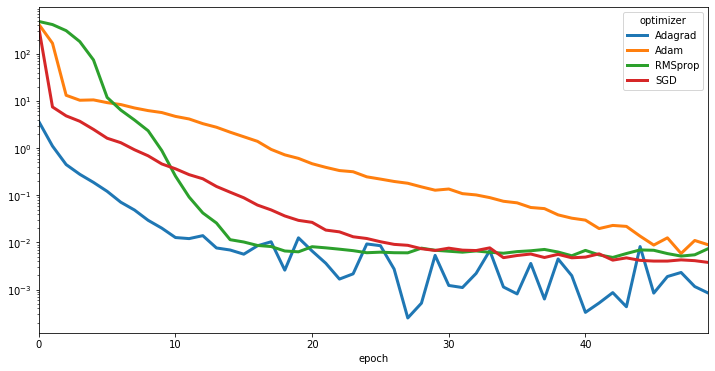

In [10]:
optimizers = [
    tf.keras.optimizers.SGD(lr=1e-3),
    tf.keras.optimizers.Adagrad(lr=1e-1),
    tf.keras.optimizers.RMSprop(lr=2e-3),
    tf.keras.optimizers.Adam(lr=3e-3)]

results = experiment(optimizers, batch_size=1024, num_epochs=50, record_steps=1)
print(results.min(axis=0))

Based on the result above, it might be tempting to say that optimizer A works better than optimizer B, but each optimizer has its own set of hyperparameters that need to be tuned to work best for the problem at hand. Without thorough experiments with the problem, it is hard to say what optimizer works the best.

### 4 Custom Optimizers  

It is pretty rare the case, but of course, we can write our own optimizers, we did so with SGD in plain tensorflow operations. But a better way is to subclass the `tf.keras.optimizers.Optimizer`.

To implement a custom optimizer, there are four methods we need to implement: 
1. `_resource_apply_dense()` - this is the method used to perform parameter updates with dense gradient tensors.
2. `_resource_apply_sparse()` - above but works with sparse gradient tensors.
3. `_create_slots()` - optionally if the optimizer require more variables. If the optimizer only uses gradients and variables(like SGD), this is not needed. 
4. `_get_config()` - optionally for save(serialize) / load(de-serialize) the optimizer with hyperparameters. 

Below we are implementing the Yogi optimizer. To dive deeper into customized optimizers, see the [optimizer](../optimizers) part of this repository. 

In [11]:
class Yogi(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate=.01, beta_1=.9, beta_2=.999, epsilon=1e-3, name='Yogi', **kwargs):
        super().__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self._set_hyper('decay', self._initial_decay) 
        self.epsilon = epsilon or tf.keras.backend.epsilon()

    def _create_slots(self, var_list):
        for var in var_list:
            self.add_slot(var, 'm')
        for var in var_list:
            self.add_slot(var, 'v', tf.constant_initializer(1.))

    def _resource_apply_dense(self, grad, var):
        dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(dtype)

        m = self.get_slot(var, 'm')
        v = self.get_slot(var, 'v')

        beta_1_t = self._get_hyper('beta_1', dtype)
        beta_2_t = self._get_hyper('beta_2', dtype)
        epsilon = tf.convert_to_tensor(self.epsilon, dtype)
        local_step = tf.cast(self.iterations + 1, dtype)
        beta_1_power = tf.pow(beta_1_t, local_step)
        beta_2_power = tf.pow(beta_2_t, local_step)

        lr = lr_t * tf.sqrt(1 - beta_2_power) / (1 - beta_1_power)

        m_t = m.assign(beta_1_t * m + (1. - beta_1_t) * grad, use_locking=self._use_locking)
        sign = tf.sign(v - tf.square(grad))
        v_t = v.assign(v - (1 - beta_2_t) * sign * tf.square(grad), use_locking=self._use_locking)

        var_update = var.assign_sub(lr * m_t / tf.sqrt(v_t + epsilon))
        updates = [var_update, m_t, v_t]
        return tf.group(*updates)
    
    def _resource_apply_sparse(self, grad, var, indices):
        dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(dtype)

        m = self.get_slot(var, 'm')
        v = self.get_slot(var, 'v')

        beta_1_t = self._get_hyper('beta_1', dtype)
        beta_2_t = self._get_hyper('beta_2', dtype)
        epsilon = tf.convert_to_tensor(self.epsilon, dtype)
        local_step = tf.cast(self.iterations + 1, dtype)
        beta_1_power = tf.pow(beta_1_t, local_step)
        beta_2_power = tf.pow(beta_2_t, local_step)

        lr = lr_t * tf.sqrt(1 - beta_2_power) / (1 - beta_1_power)

        m_scaled_g_values = (1. - beta_1_t) * grad
        m_t = m.assign(beta_1_t * m, use_locking=self._use_locking)
        with tf.control_dependencies([m_t]):
            m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)

        sign = tf.sign(tf.gather(v, indices) - tf.square(grad))

        v_scaled_g_values = (1. - beta_2_t) * sign * tf.square(grad)
        v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)

        var_update = self._resource_scatter_sub(var, indices, lr * m_t / tf.sqrt(v_t + epsilon))
        updates = [var_update, m_t, v_t]
        return tf.group(*updates)


    def get_config(self):
        config = super(Yogi, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'beta_1': self._serialize_hyperparameter('beta_1'),
            'beta_2': self._serialize_hyperparameter('beta_2'),
            'decay': self._serialize_hyperparameter('decay'),
            'epsilon': self.epsilon
        })
        return config


optimizer
Adagrad    0.000251
Adam       0.005849
RMSprop    0.004817
SGD        0.003772
Yogi       0.000008
dtype: float64


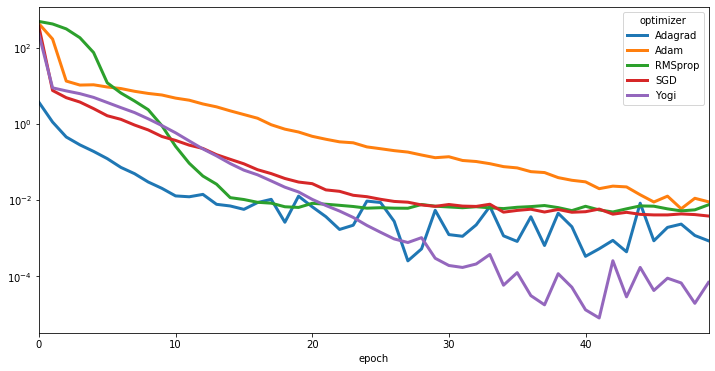

In [12]:
model, history = opt(model=LinearModel(num_units=[5,3,1], use_bias=True), 
                     criterion=criterion, 
                     optimizer=Yogi(),
                     batch_size=1024, 
                     num_epochs=50, 
                     record_steps=1)

results['Yogi'] = history['loss']
results.plot(logy=True, figsize=(12,6), linewidth=3)
print(results.min(axis=0))

The result from Yogi looks great, right? But again, have I done thorough experiments with each optimizers? 